# ___

# [ Machine Learning in Geosciences ]

## **Test 1 solution** 

*Author: Anna Kožíšková

*Date: 8.4.2024 

___


### 1.1 The Problem

TASK: Predict Forest Fires using Meteorological Data

Context: "Forest fires are a major environmental issue, creating economical and ecological damage while endangering human lives. Fast detection is a key element for controlling such phenomenon. To achieve this, one alternative is to use automatic tools based on local sensors, such as provided by meteorological stations. In effect, meteorological conditions (e.g. temperature, wind) are known to influence forest fires and several fire indexes, such as the forest Fire Weather Index (FWI), you can use such features, see below the figure for feature engineering. 
In this work, we explore a Machine Learning (ML) approach to **predict the burned area of forest fires**.


### 1.2 Assumptions

* The problem is a multivariate regression (will use multiple features to make a prediction); 
* There is no continuous flow of data, hence batch learning shall be applied; 
* The meterological data are good indicators of the forest fire; 
* There are enough variables (features) to predict the forest fire. 


### 1.3 Expected results 

* Machine Learning model to predict the burned area of the forest fires based on the meterological data. 
___    

### Weather features

<div>
<img src="attachment:image.png" width="600">
</div>

### Input data atrributes description

**Attribute information**

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn > 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
   from future_encoders import OneHotEncoder # Scikit-Learn < 0.20
np.random.seed(42)

In [2]:
# Input data 
'./machine_learning_geosciences/LAB_mlgeo_test_1/data/forestfires.csv'
# Inport data 

df = pd.read_csv('./data/forestfires.csv')

### 2 Data exploration

In [3]:
df.head()
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


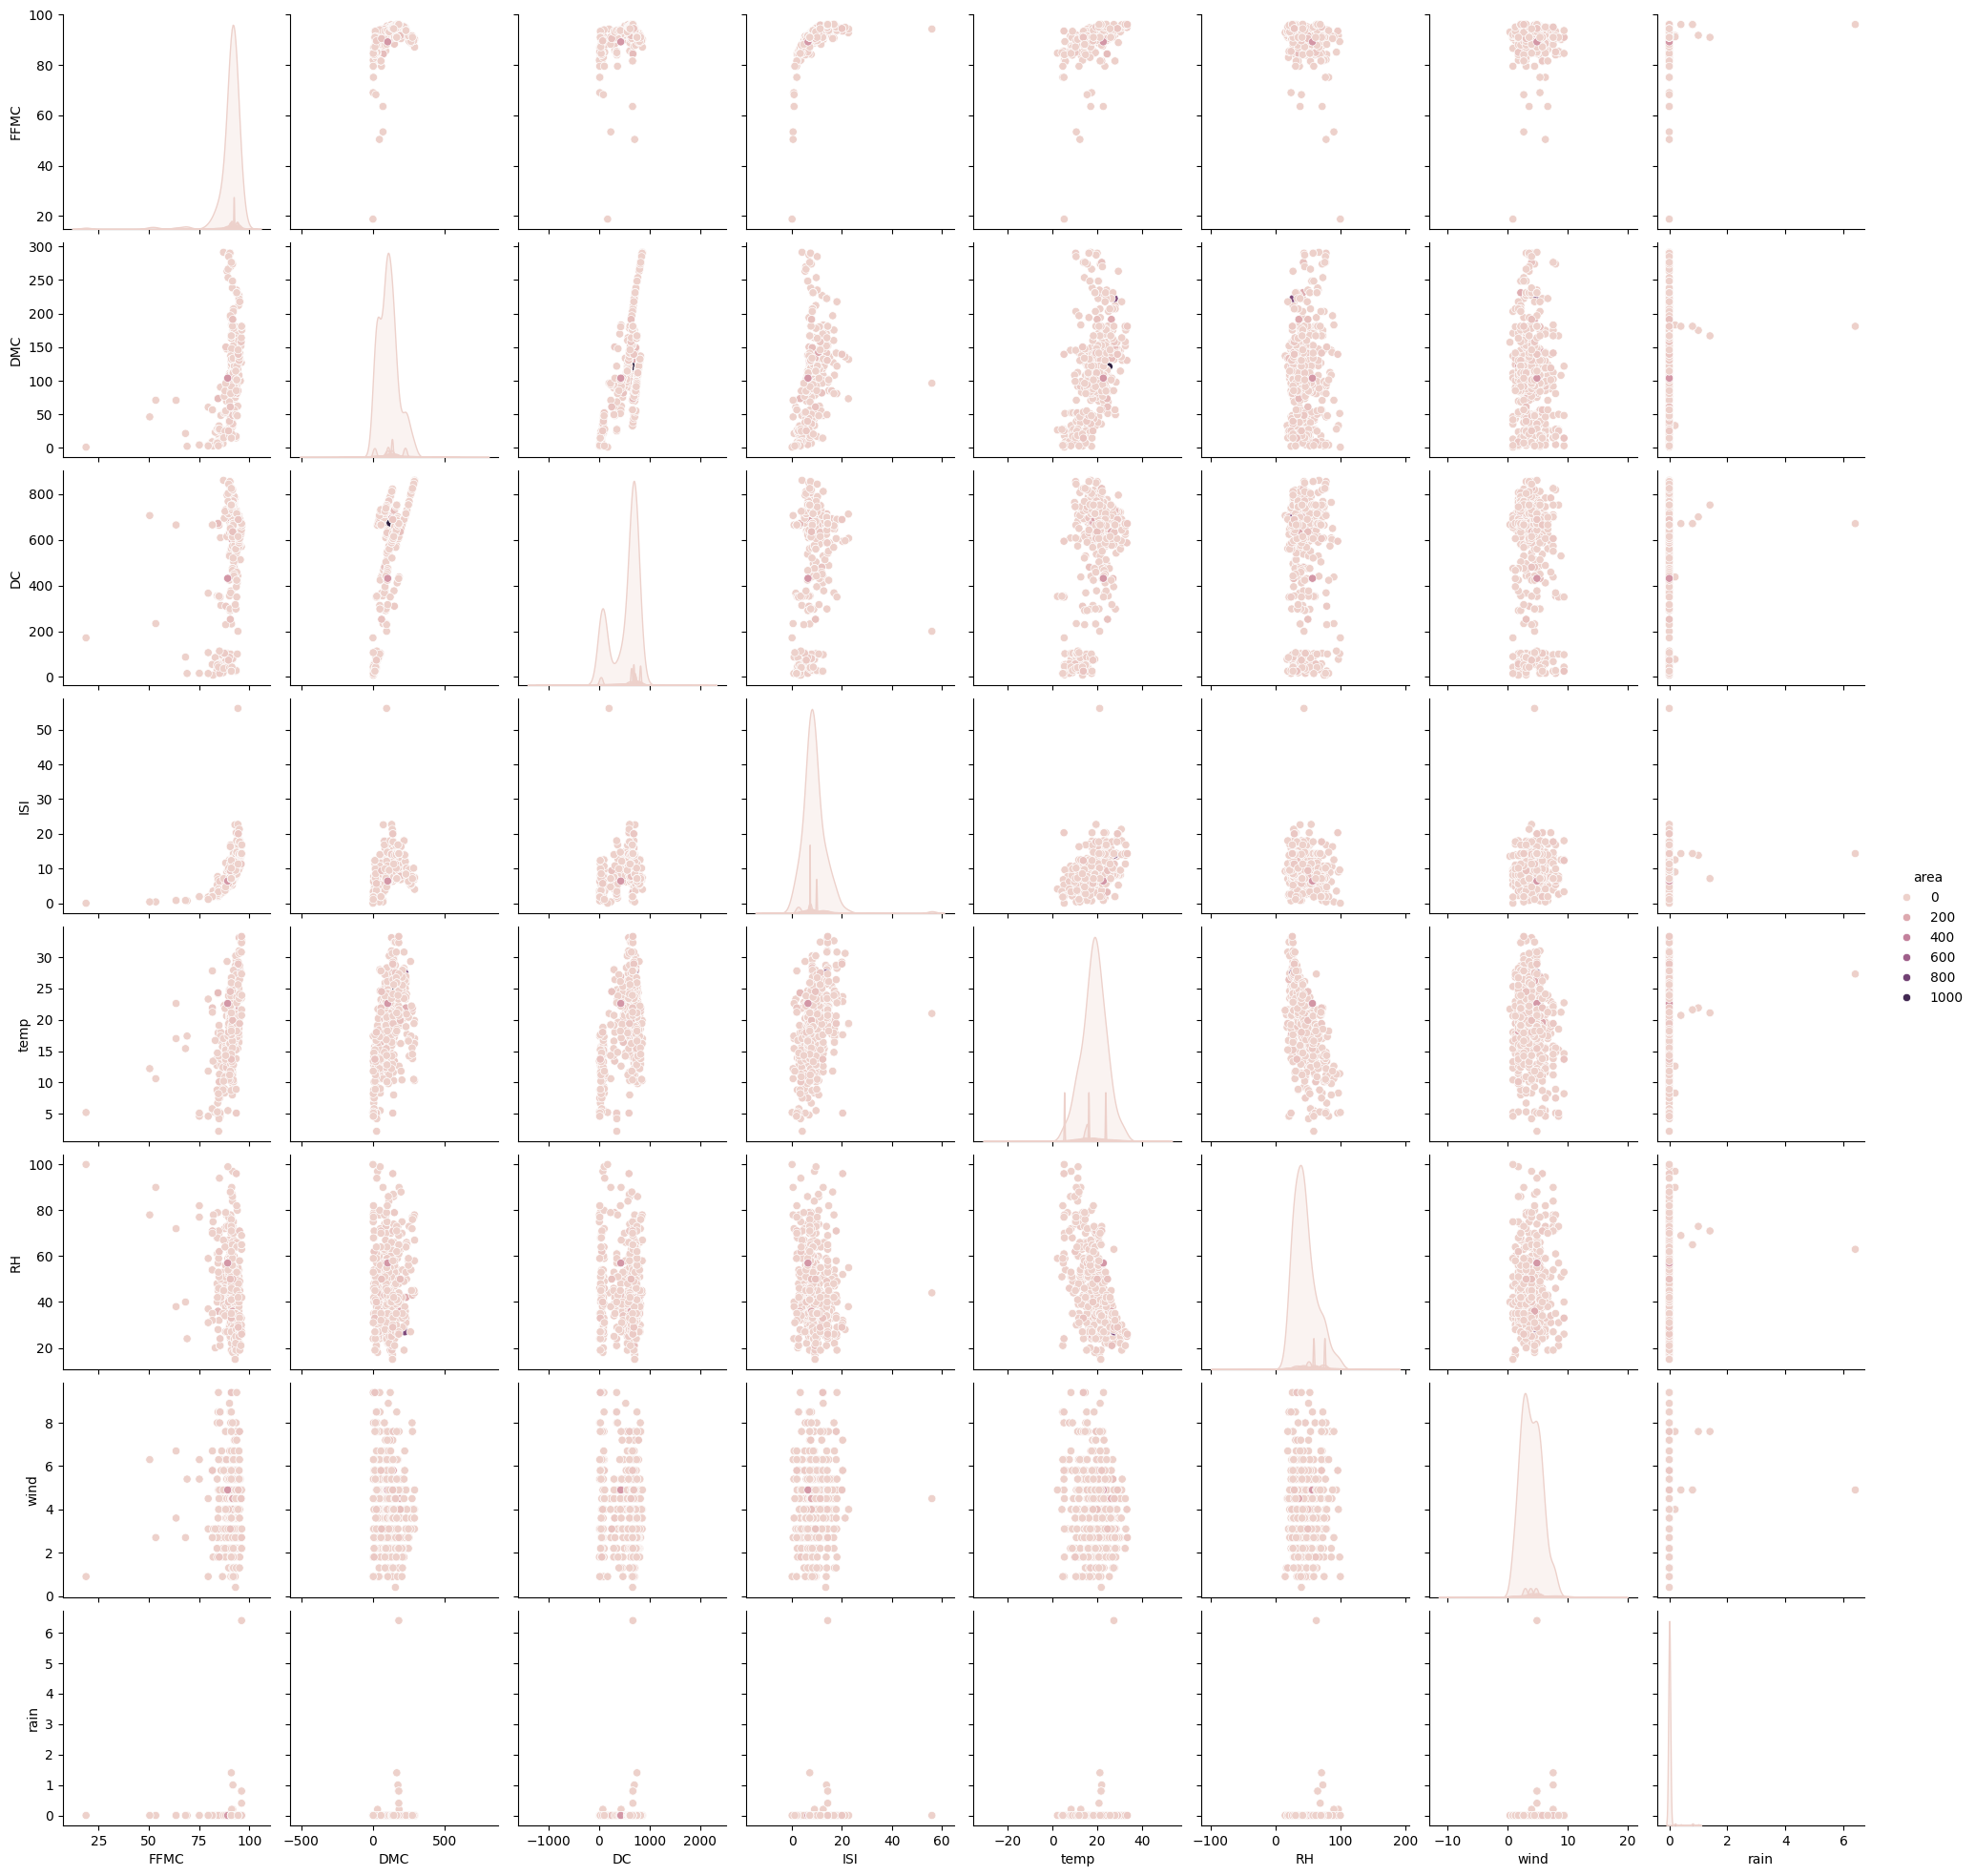

In [260]:
#create data set without first 4 columns
data = df.iloc[:,4:]
#
data.shape
sns.pairplot(data, hue='area')

#### outlying values!

there are outliers in the data - this is reflected in the result

### 3. Data preparation

In [261]:
# correlation matrix
corr_matrix = data.corr()
corr_matrix["area"].sort_values(ascending=False)

area    1.000000
temp    0.097844
DMC     0.072994
DC      0.049383
FFMC    0.040122
wind    0.012317
ISI     0.008258
rain   -0.007366
RH     -0.075519
Name: area, dtype: float64

s hodnotou "area" nejvíce koreluje teplota - "temp"

In [281]:
# check for missing values
print(data[data.isnull().any(axis=1)])

Empty DataFrame
Columns: [FFMC, DMC, DC, ISI, temp, RH, wind, rain, area, temp_cat]
Index: []
Empty DataFrame
Columns: [X, Y, month, day, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area]
Index: []


In [300]:
# encoder = OneHotEncoder()
# encoding month feature into numerical values
encoder= OneHotEncoder(sparse_output=False).set_output(transform="pandas")
encoder.fit(df[["month"]])
month_num = encoder.transform(df[["month"]])
month_num.head()

,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [301]:
data_merged = pd.concat([data, month_num], axis=1)
data_merged.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,temp_cat,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Split data into train and test sets

In [171]:
# unstratisfied split

# preparing training and testing sets
# from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(data, test_size=0.5, random_state=42)

<Axes: >

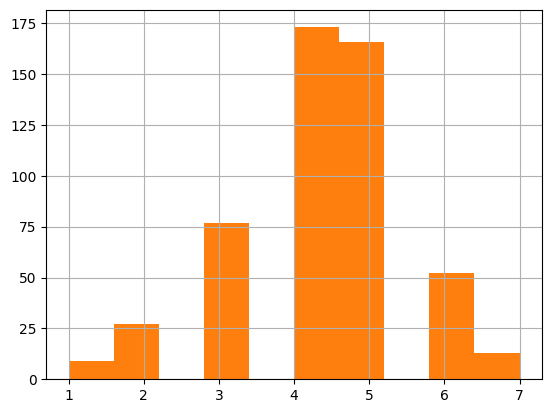

In [302]:
# stratified sampling
"""data["temp_cat"] = pd.cut(data["temp"],
                               bins=[0., 5., 10., 15., 20., 25., 30., np.inf],
                                labels=[1, 2, 3, 4, 5, 6, 7])

data["temp_cat"].hist()"""

# with month feaeture
# cutting the temperature feature into categories
data_merged["temp_cat"] = pd.cut(data_merged["temp"],
                               bins=[0., 5., 10., 15., 20., 25., 30., np.inf],
                                labels=[1, 2, 3, 4, 5, 6, 7])
data_merged["temp_cat"].hist()

In [303]:
#data["temp_cat"]
data_merged["temp_cat"]

0      2
1      4
2      3
3      2
4      3
      ..
512    6
513    5
514    5
515    6
516    3
Name: temp_cat, Length: 517, dtype: category
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [317]:
# Do stratified sampling based on the tempeture
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

# random uniform distribution of the test and training set based on the temp_cat column
for train_index, test_index in sss.split(data_merged, data_merged["temp_cat"]):
    strat_train_set = data_merged.loc[train_index]
    strat_test_set = data_merged.loc[test_index]

In [318]:
# chcecking the dataset after stratified sampling
strat_train_set.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,temp_cat,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
438,93.7,231.1,715.1,8.4,23.6,53,4.0,0.0,6.43,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,91.7,114.3,661.3,6.3,18.6,44,4.5,0.0,0.00,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,90.2,96.9,624.2,8.9,18.4,42,6.7,0.0,0.00,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
440,90.3,290.0,855.3,7.4,16.2,58,3.6,0.0,0.00,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
193,92.9,133.3,699.6,9.2,24.3,25,4.0,0.0,9.41,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [319]:
# the income category proportions in test set
strat_test_set["temp_cat"].value_counts() / len(strat_test_set)

temp_cat
4    0.335907
5    0.320463
3    0.150579
6    0.100386
2    0.054054
7    0.023166
1    0.015444
Name: count, dtype: float64

In [320]:
# the income category proportions in the full dataset
#data["temp_cat"].value_counts() / len(data)
data_merged["temp_cat"].value_counts() / len(data_merged)

temp_cat
4    0.334623
5    0.321083
3    0.148936
6    0.100580
2    0.052224
7    0.025145
1    0.017408
Name: count, dtype: float64

In [321]:
# dividing into X and y sets
X_train = strat_train_set.drop("area", axis = 1)
y_train = strat_train_set["area"]
X_test = strat_test_set.drop("area", axis = 1)
y_test = strat_test_set["area"]
#X_train.shape
#y_train.shape

# 4. Select and train a model 

In [322]:
# initiate model
forest_reg = RandomForestRegressor(random_state=42)

In [323]:
#tune the model
hyper_parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [10, 15, 20, 25, 30],
    "min_samples_leaf": [2, 4, 6, 8] 
}

In [324]:
gs = GridSearchCV(forest_reg, hyper_parameters, n_jobs=4, cv=10,  scoring="neg_mean_absolute_error", return_train_score=True)

In [325]:
#fitting data
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=4,
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [326]:
# best parameters
gs.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 150}

In [327]:
# saving the best model
my_fin_model = gs.best_estimator_

In [328]:
# y_train predict and calcualting the error
y_train_predict = my_fin_model.predict(X_train)
mae_train_error = mean_absolute_error(y_train,y_train_predict)
print(f"Maen abs error of train set: {mae_train_error}")

Maen abs error of train set: 10.357311304528537


In [329]:
# y_test predict and calcualting the error
y_test_predict = my_fin_model.predict(X_test)
mae_test_error = mean_absolute_error(y_test,y_test_predict)
print(f"Maen abs error of test set: {mae_test_error}")

Maen abs error of test set: 20.53339918066526


In [330]:
# realative error
relative_error = mae_test_error / y_test.mean()
relative_error

1.21556889616581

Výsledné nejsou moc uspokojivé - zřejmě kvůli odlehlýmh odnotám